In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Heart_Disease/heart_statlog_cleveland_hungary_final.csv')
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


Rename feature columns

In [3]:
df.rename(columns={'chest pain type':'chest_pain','resting bp s':'resting_blood_pressure','fasting blood sugar':'high_blood_sugar','resting ecg':'resting_ecg','max heart rate':'max_heart_rate','exercise angina':'exercise_angina','ST slope':'ST_slope','target':'heart_disease'}, inplace=True)

Preliminary check of the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1190 non-null   int64  
 1   sex                     1190 non-null   int64  
 2   chest_pain              1190 non-null   int64  
 3   resting_blood_pressure  1190 non-null   int64  
 4   cholesterol             1190 non-null   int64  
 5   high_blood_sugar        1190 non-null   int64  
 6   resting_ecg             1190 non-null   int64  
 7   max_heart_rate          1190 non-null   int64  
 8   exercise_angina         1190 non-null   int64  
 9   oldpeak                 1190 non-null   float64
 10  ST_slope                1190 non-null   int64  
 11  heart_disease           1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [5]:
df.isnull().any()

age                       False
sex                       False
chest_pain                False
resting_blood_pressure    False
cholesterol               False
high_blood_sugar          False
resting_ecg               False
max_heart_rate            False
exercise_angina           False
oldpeak                   False
ST_slope                  False
heart_disease             False
dtype: bool

In [6]:
df['heart_disease'].value_counts()

heart_disease
1    629
0    561
Name: count, dtype: int64

In [7]:
df.duplicated().any()

True

In [8]:
df.drop_duplicates(inplace = True)
df.duplicated().any()

False

In [9]:
df['heart_disease'].value_counts()

heart_disease
1    508
0    410
Name: count, dtype: int64

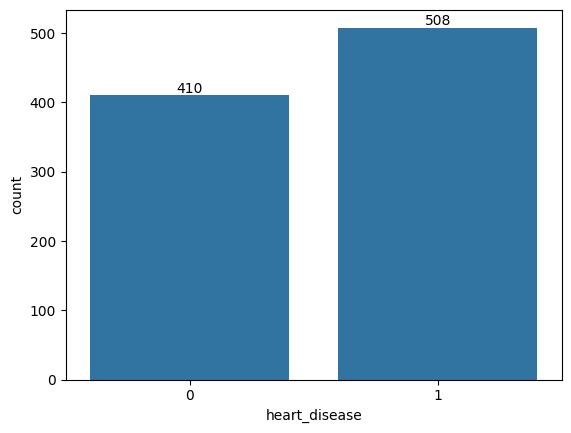

In [10]:
label_plot = sns.countplot(x=df['heart_disease'])
label_plot.bar_label(label_plot.containers[0])
plt.show()

Cleaning data

In [11]:
df.replace({'chest_pain':{1:'typical_angina',2:'atypical_angina',3:'non-anginal_pain',4:'asymptomatic'}},inplace=True)
df.replace({'chest_pain':{'asymptomatic':0,'non-anginal_pain':1,'atypical_angina':2,'typical_angina':3}},inplace=True)

In [12]:
df.replace({'ST_slope':{3:-1,2:0,1:1}},inplace=True)

In [13]:
df.replace({'sex':{1:'male',0:'female'}},inplace=True)
df.replace({'sex':{'male':0,'female':1}},inplace=True)

In [14]:
df.head()

,age,sex,chest_pain,resting_blood_pressure,cholesterol,high_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,ST_slope,heart_disease
0,40,0,2,140,289,0,0,172,0,0.0,1,0
1,49,1,1,160,180,0,0,156,0,1.0,0,1
2,37,0,2,130,283,0,1,98,0,0.0,1,0
3,48,1,0,138,214,0,0,108,1,1.5,0,1
4,54,0,1,150,195,0,0,122,0,0.0,1,0


In [15]:
col_names = df.columns.tolist()

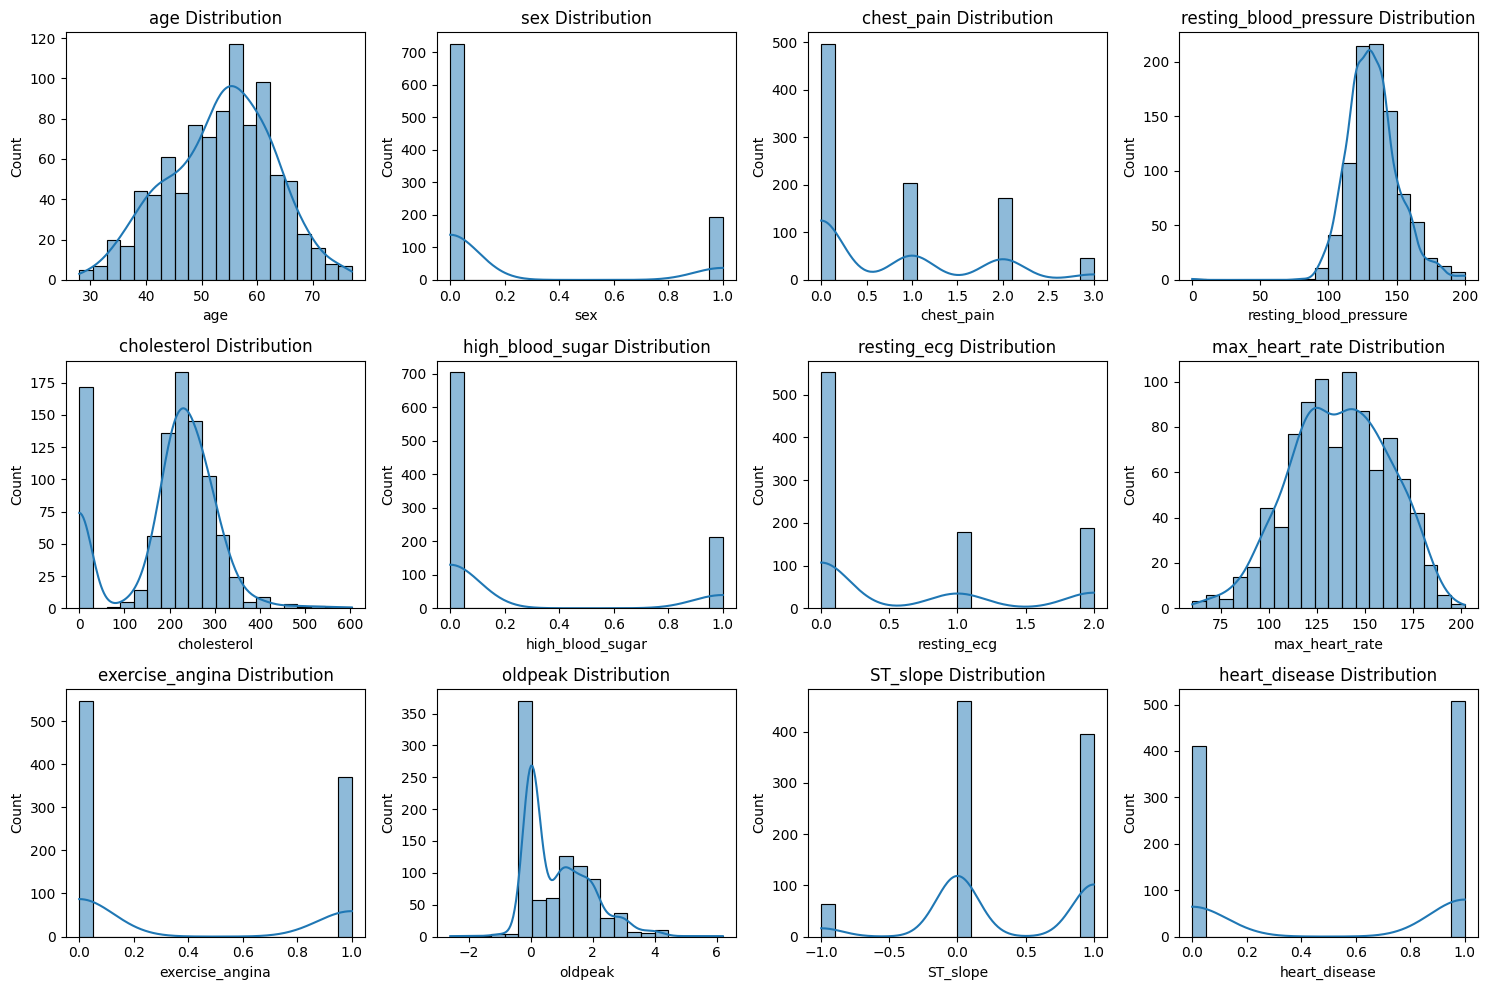

In [16]:
plt.figure(figsize=(15,10))
for i in range(len(col_names)):
  plt.subplot(3,4,i+1)
  sns.histplot(data=df, x=df[col_names[i]], bins=20, kde=True)
  plt.title(f'{col_names[i]} Distribution')
plt.tight_layout()
plt.show()

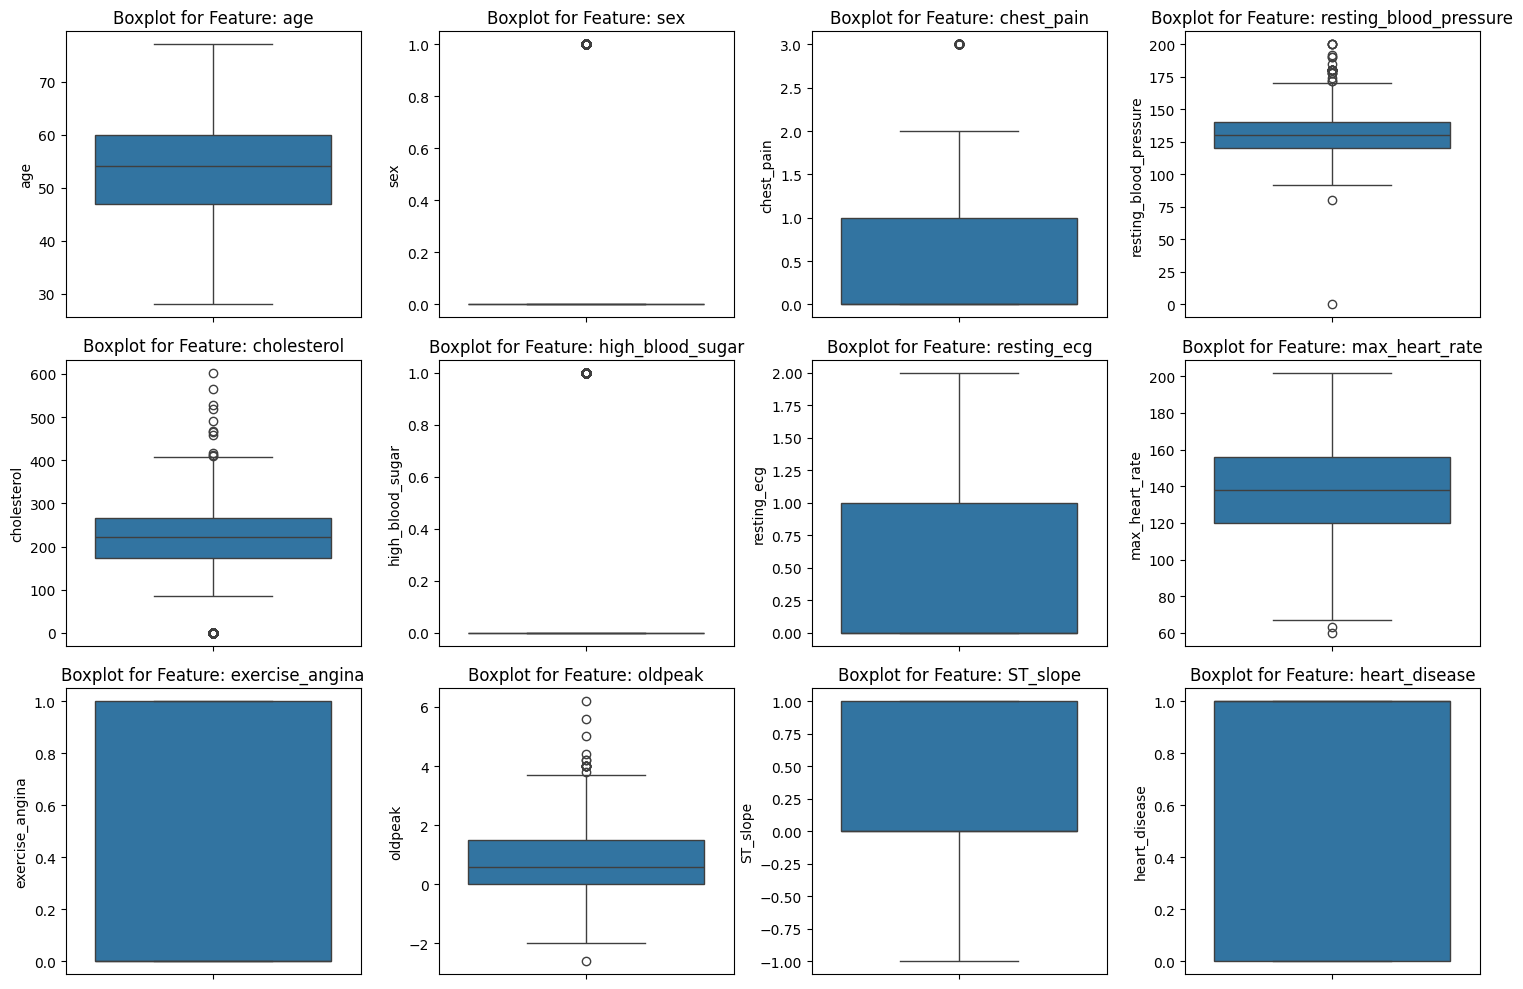

In [17]:
plt.figure(figsize=(15,10))
for i in range(len(col_names)):
  plt.subplot(3,4,i+1)
  sns.boxplot(y=df[col_names[i]], data=df)
  plt.title(f'Boxplot for Feature: {col_names[i]}')
plt.tight_layout()
plt.show()

From the cholesterol and resting blood pressure distribution plots, we can see that there are instances where the value is equal to 0, which is impossible in a medical context. This could be due to a small mistake during data collection, but we cannot determine which value is correct to fix it. Therefore, I will remove them from this dataset.

In [18]:
df = df.loc[(df['cholesterol']>0)]
df['heart_disease'].value_counts()

heart_disease
0    390
1    356
Name: count, dtype: int64

In [19]:
df.loc[(df['resting_blood_pressure']==0)].any()

age                       False
sex                       False
chest_pain                False
resting_blood_pressure    False
cholesterol               False
high_blood_sugar          False
resting_ecg               False
max_heart_rate            False
exercise_angina           False
oldpeak                   False
ST_slope                  False
heart_disease             False
dtype: bool

I've dropped 172 instances.

Visualize and analyze

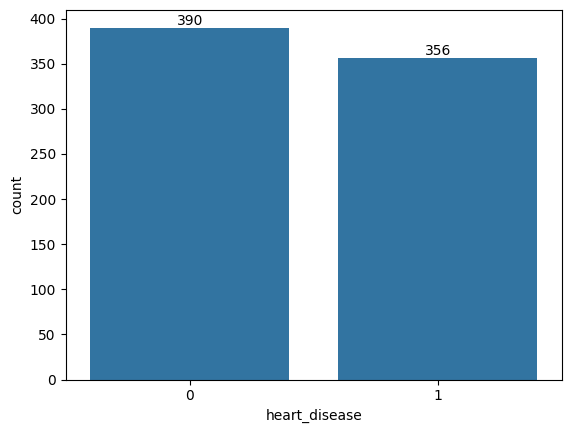

In [20]:
label_plot = sns.countplot(x=df['heart_disease'])
label_plot.bar_label(label_plot.containers[0])
plt.show()

After dropping some error cases, there are 390 instances labeled as 0 and 156 instances labeled as 1 remaining. The output labels appear to be quite balanced.

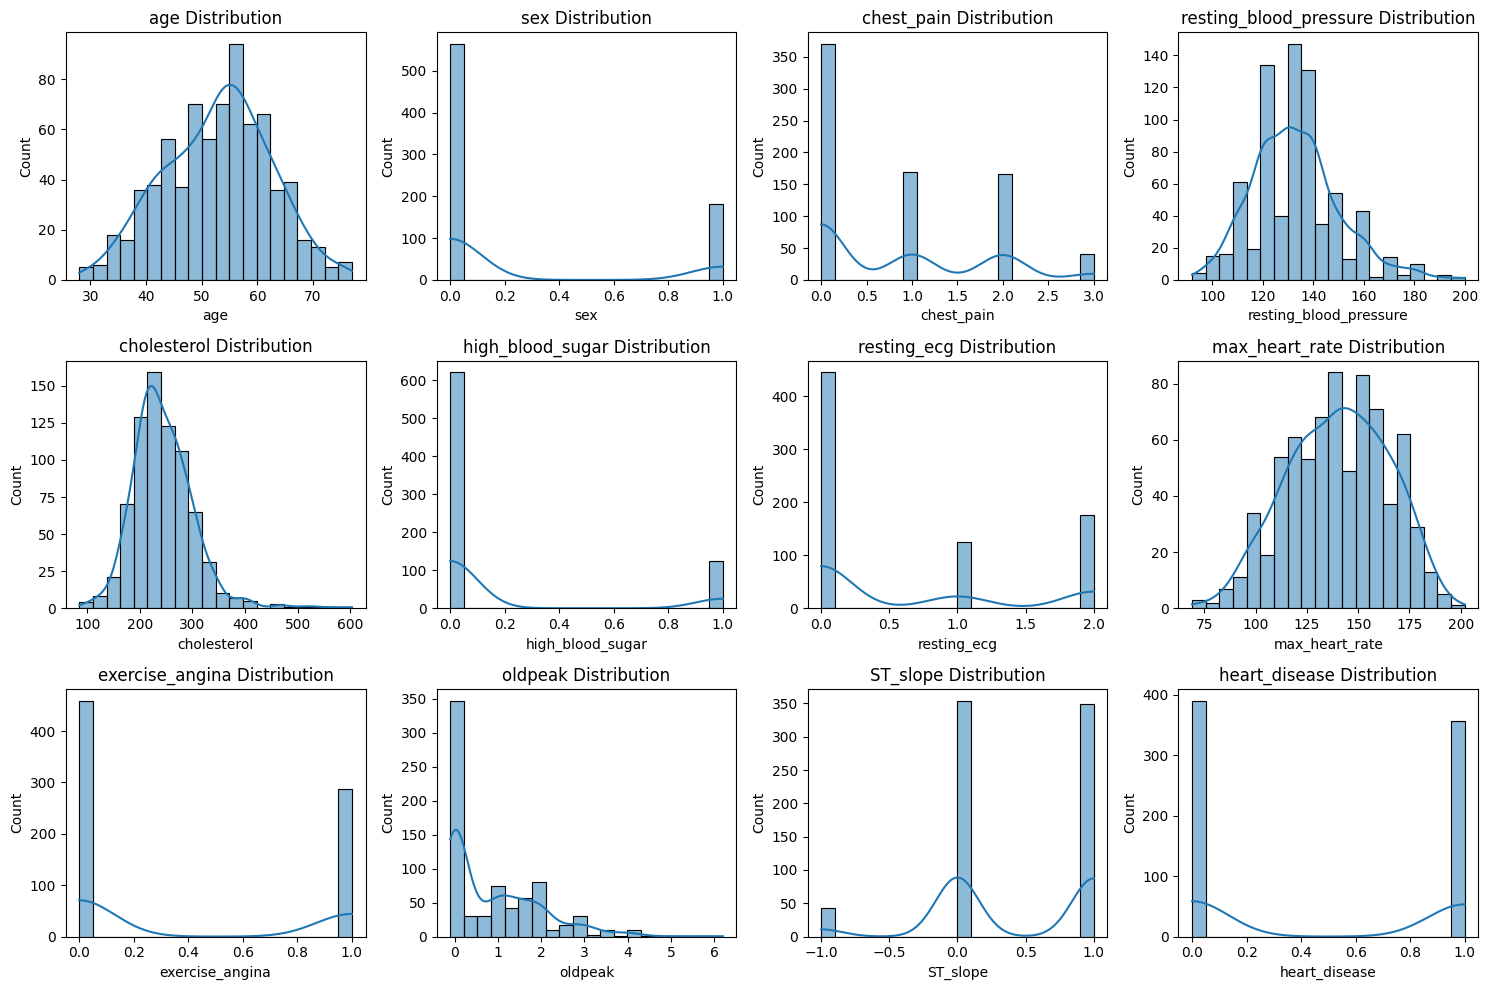

In [21]:
plt.figure(figsize=(15,10))
# plt.title('Features Distribution')
for i in range(len(col_names)):
  plt.subplot(3,4,i+1)
  sns.histplot(data=df, x=df[col_names[i]], bins=20, kde=True)
  plt.title(f'{col_names[i]} Distribution')
plt.tight_layout()
plt.show()

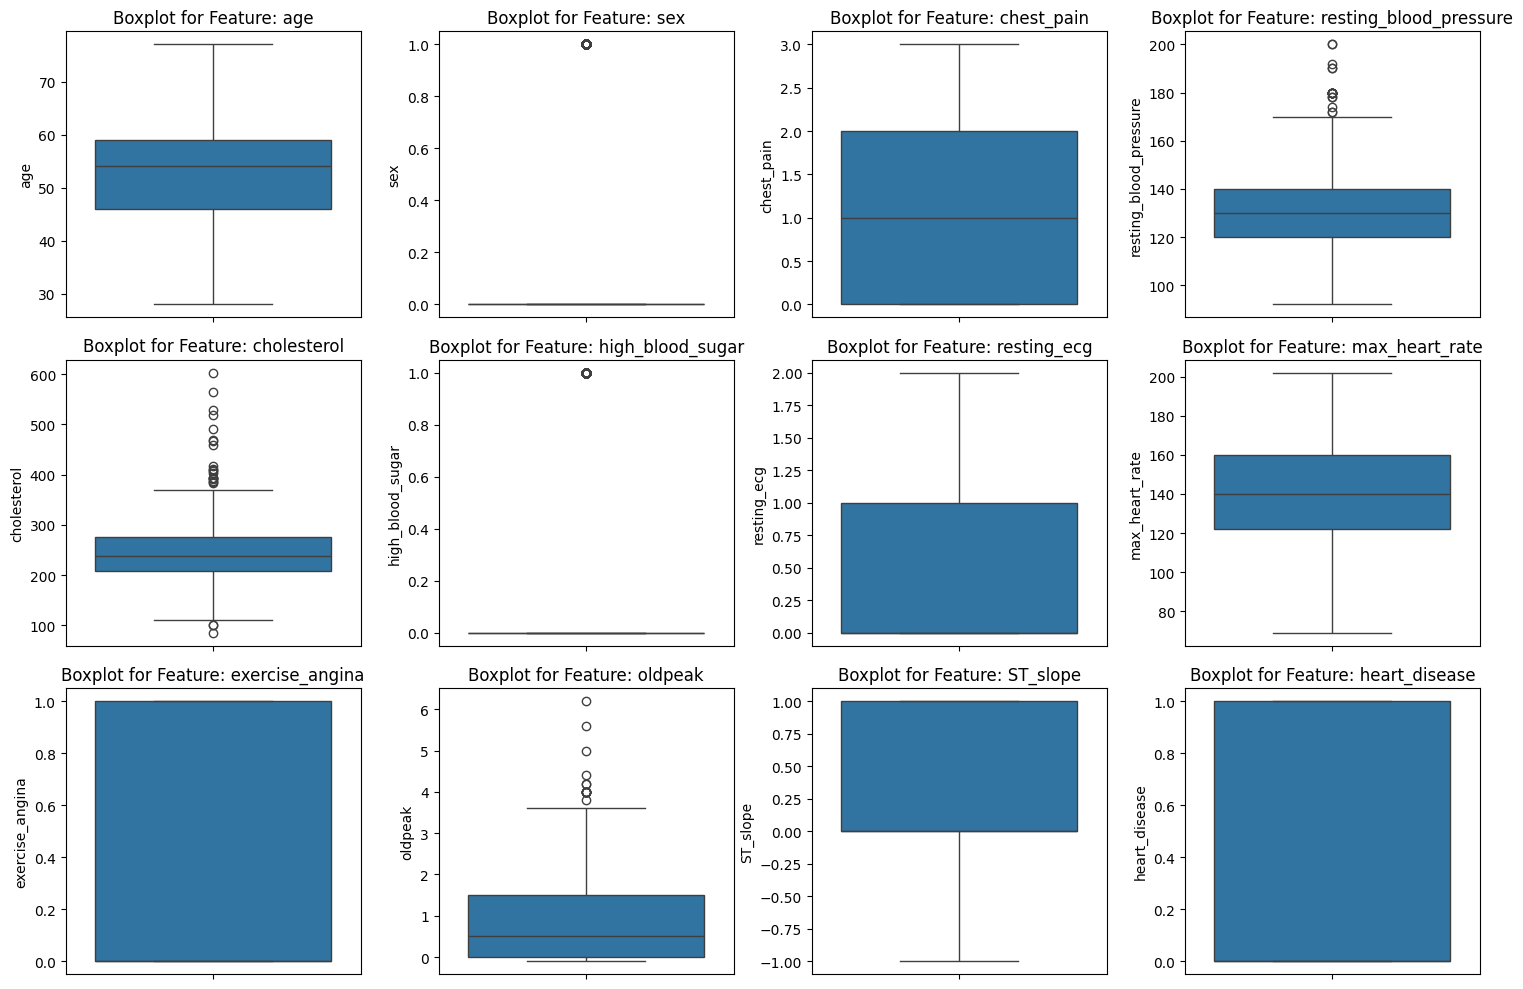

In [22]:
plt.figure(figsize=(15,10))
for i in range(len(col_names)):
  plt.subplot(3,4,i+1)
  sns.boxplot(y=df[col_names[i]], data=df)
  plt.title(f'Boxplot for Feature: {col_names[i]}')
plt.tight_layout()
plt.show()

The distribution of all features is now more reliable because some outlier cases, such as resting blood pressure = 0 or maximum heart rate lower than 70, have also been dropped when I removed all instances where 'cholesterol' = 0.

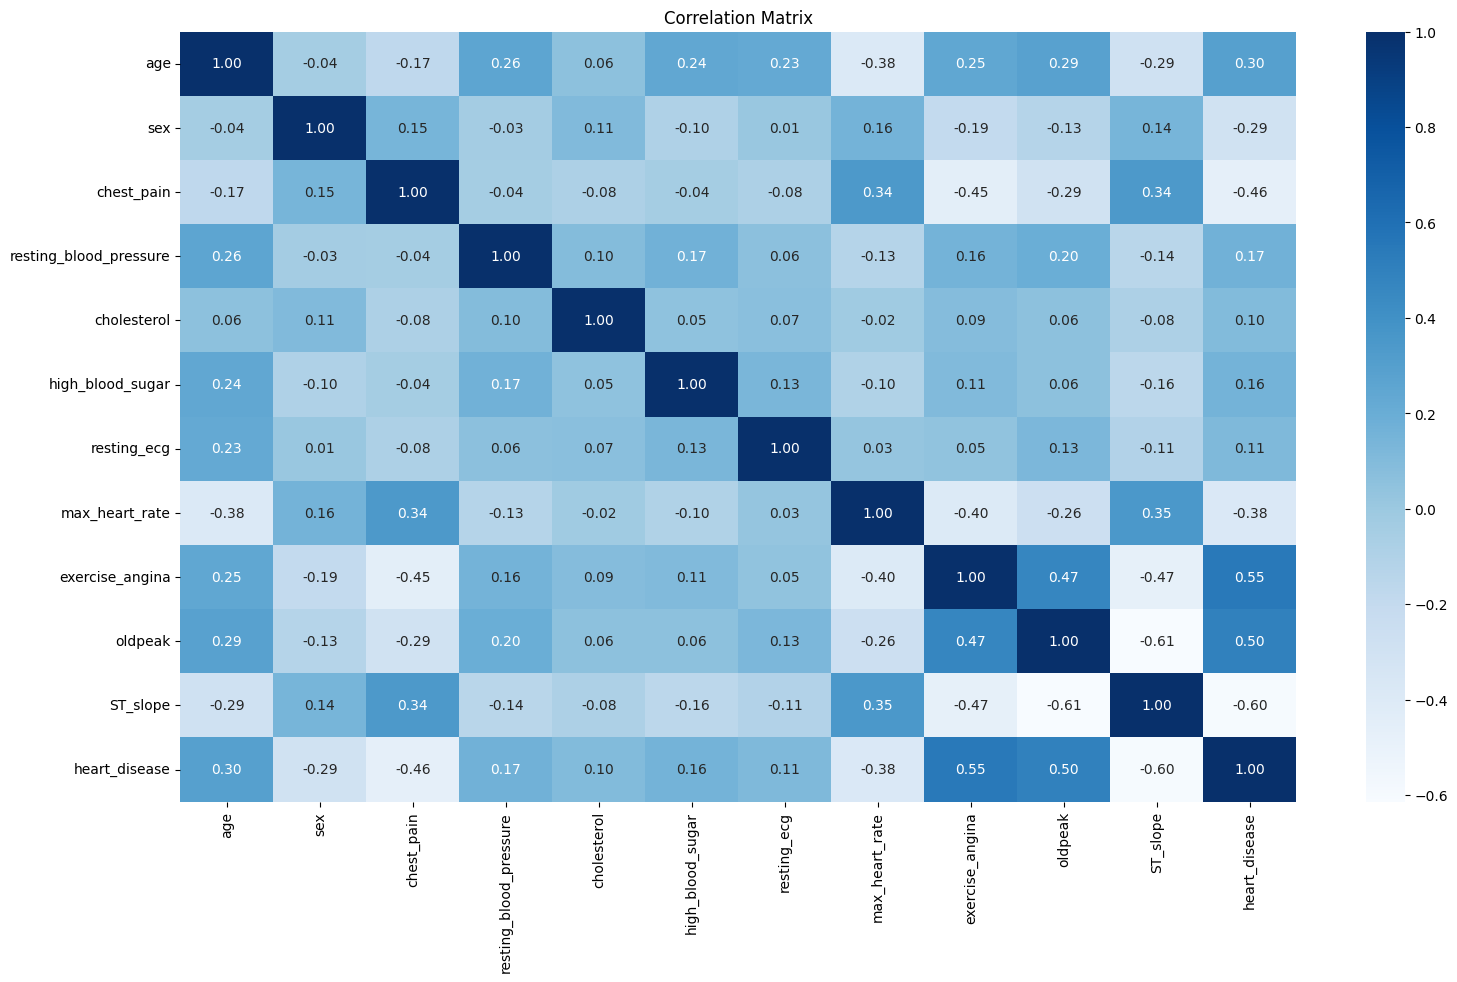

In [23]:
plt.figure(figsize=(18, 10))
sns.heatmap(df.corr(), annot=True, cbar=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

From the correlation matrix, we can observe that features such as 'age', 'exercise_angina', and 'oldpeak' exhibit strong positive correlations with the output 'heart_disease'. This suggests that higher values of 'age', 'exercise_angina', and 'oldpeak' correspond to a higher likelihood of the output being 'heart_disease' = 1. Conversely, features such as 'sex', 'chest_pain', 'max_heart_rate', and 'ST_slope' display strong negative correlations with the output 'heart_disease'. This indicates that lower values of 'sex', 'chest_pain', 'max_heart_rate', and 'ST_slope' are associated with a higher likelihood of the output being 'heart_disease' = 1. Other features have a slightly weaker correlation compared to the aforementioned ones.

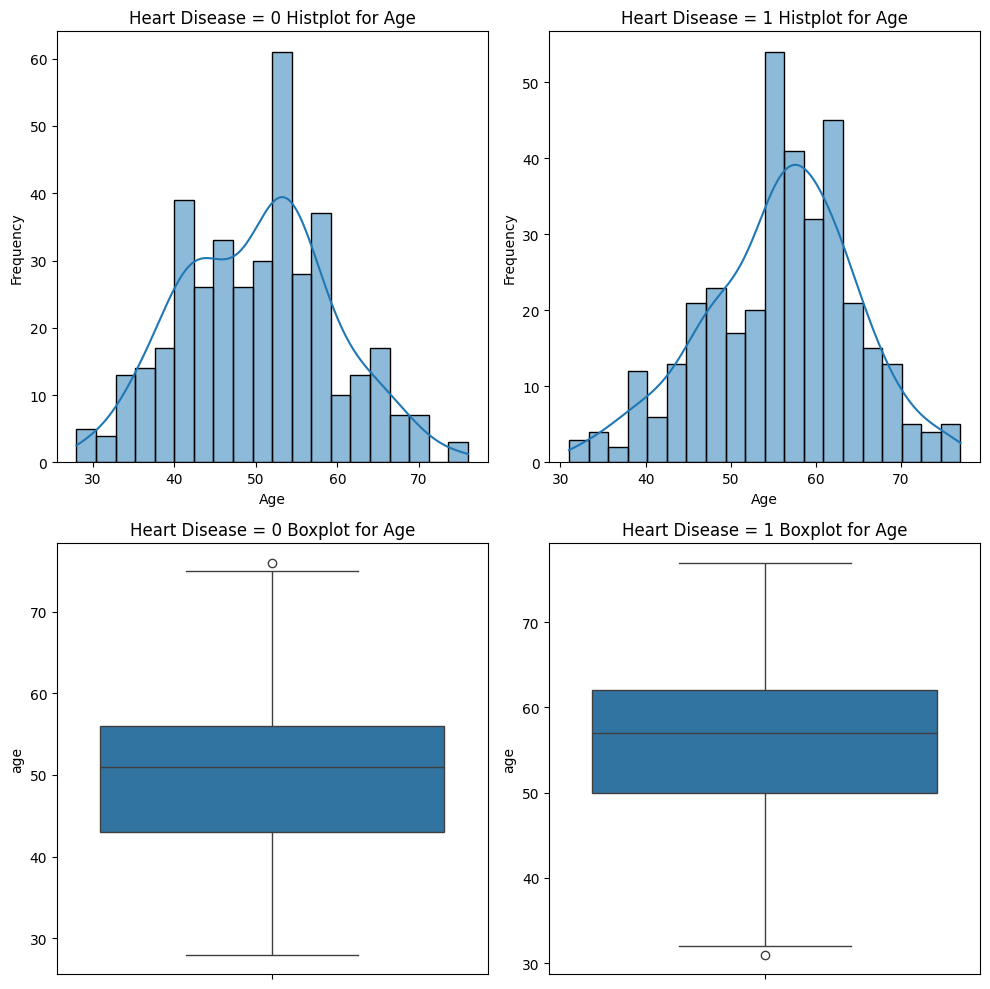

In [24]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=df.loc[df['heart_disease'] == 0], x='age', bins=20, kde=True)
plt.title('Heart Disease = 0 Histplot for Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(data=df.loc[df['heart_disease'] == 1], x='age', bins=20, kde=True)
plt.title('Heart Disease = 1 Histplot for Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.boxplot(y='age', data=df.loc[df['heart_disease'] == 0])
plt.title('Heart Disease = 0 Boxplot for Age')

plt.subplot(2, 2, 4)
sns.boxplot(y='age', data=df.loc[df['heart_disease'] == 1])
plt.title('Heart Disease = 1 Boxplot for Age')

plt.tight_layout()
plt.show()

The distribution of the 'age' feature differs between cases where the output is labeled as 0 and 1, particularly around the age of 54. When 'heart_disease' = 0, there are numerous instances distributed in the age range lower than 54. Conversely, when 'heart_disease' = 1, the distribution is more focused on the age range higher than 54.

Because of that, I have divided the 'age' feature into two ranges: lower than 54 and higher than 54, and engineered a new feature based on these two ranges.

In [25]:
low_age = (df['age']<54)*1
high_age = (df['age']>=54)*2
df['age_range'] = low_age + high_age

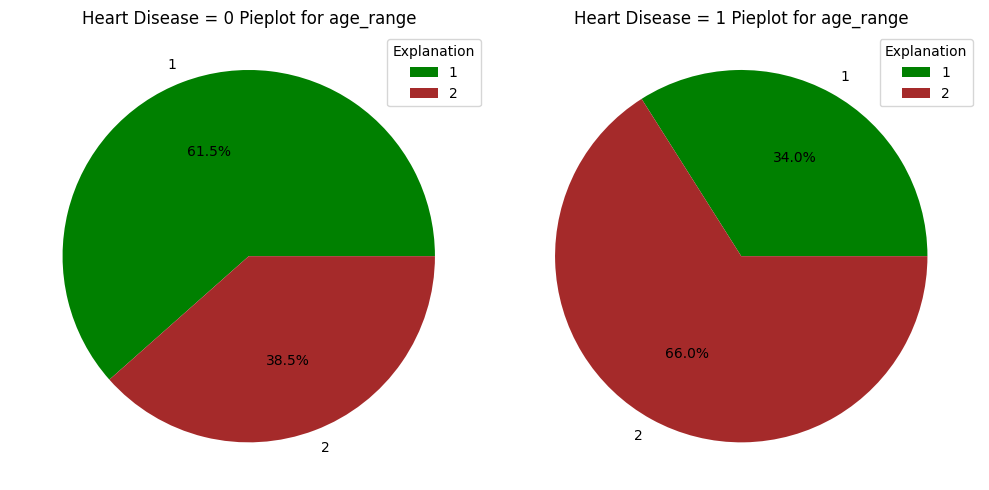

In [26]:
label_colors = {-1: 'red', 0: 'blue', 1: 'green', 2: 'brown', 3: 'orange', 4: 'purple'}

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sizes = df.loc[df['heart_disease'] == 0, 'age_range'].value_counts()
labels = sizes.index
# Sort labels and sizes
labels_sorted = sorted(labels)
sizes_sorted = [sizes[label] for label in labels_sorted]
plt.pie(sizes_sorted, labels=labels_sorted, autopct='%1.1f%%', colors=[label_colors[label] for label in labels_sorted])
plt.title('Heart Disease = 0 Pieplot for age_range')
plt.legend(loc='upper right', title='Explanation', labels=labels_sorted)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.subplot(1,2,2)
sizes = df.loc[df['heart_disease'] == 1, 'age_range'].value_counts()
labels = sizes.index
# Sort labels and sizes
labels_sorted = sorted(labels)
sizes_sorted = [sizes[label] for label in labels_sorted]
plt.pie(sizes_sorted, labels=labels_sorted, autopct='%1.1f%%', colors=[label_colors[label] for label in labels_sorted])
plt.title('Heart Disease = 1 Pieplot for age_range')
plt.legend(loc='upper right', title='Explanation', labels=labels_sorted)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

We can see the difference more clearly through these pie plots. When 'heart_disease' value equals 0, the distribution of these instances focuses mostly on the lower range, below 54, represented by the value of 1. Conversely, when 'heart_disease' value equals 1, the distribution of these instances focuses mostly on the higher range, above 54, represented by the value of 2.

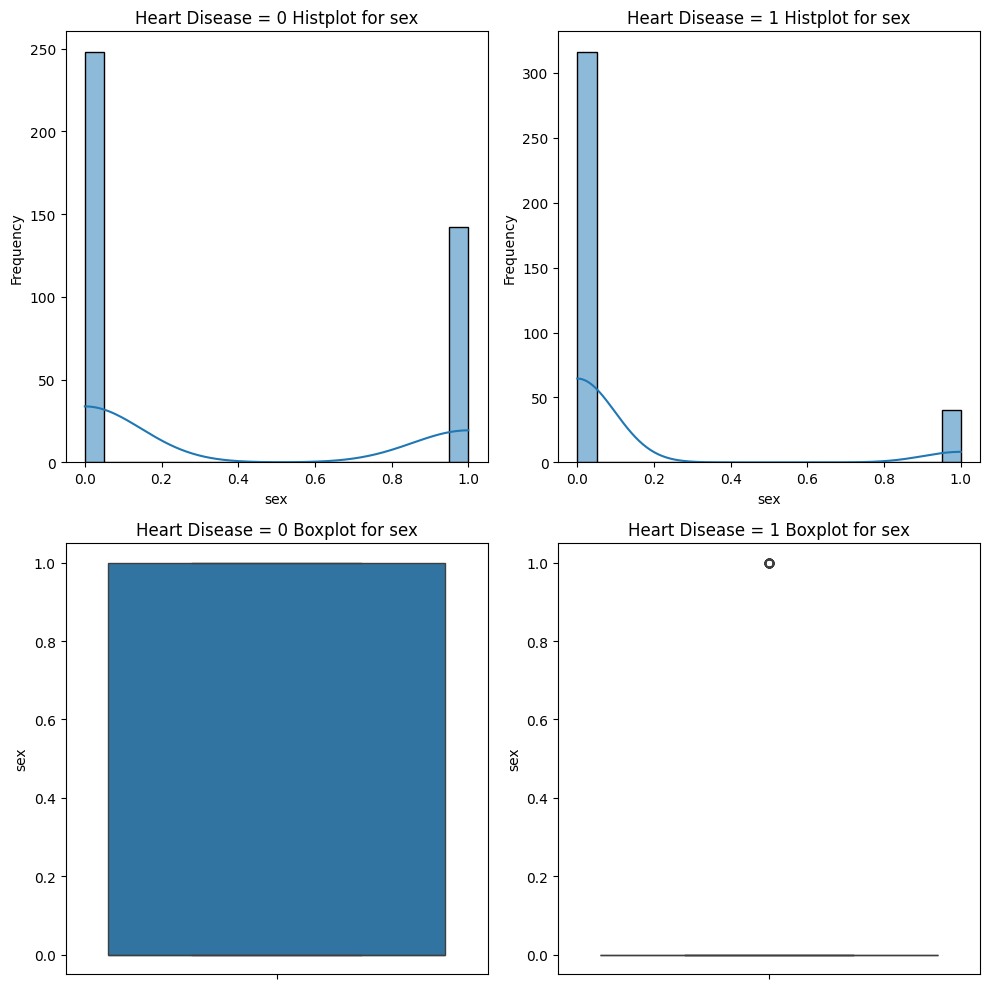

In [27]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=df.loc[df['heart_disease'] == 0], x='sex', bins=20, kde=True)
plt.title('Heart Disease = 0 Histplot for sex')
plt.xlabel('sex')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(data=df.loc[df['heart_disease'] == 1], x='sex', bins=20, kde=True)
plt.title('Heart Disease = 1 Histplot for sex')
plt.xlabel('sex')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.boxplot(y='sex', data=df.loc[df['heart_disease'] == 0])
plt.title('Heart Disease = 0 Boxplot for sex')

plt.subplot(2, 2, 4)
sns.boxplot(y='sex', data=df.loc[df['heart_disease'] == 1])
plt.title('Heart Disease = 1 Boxplot for sex')

plt.tight_layout()
plt.show()

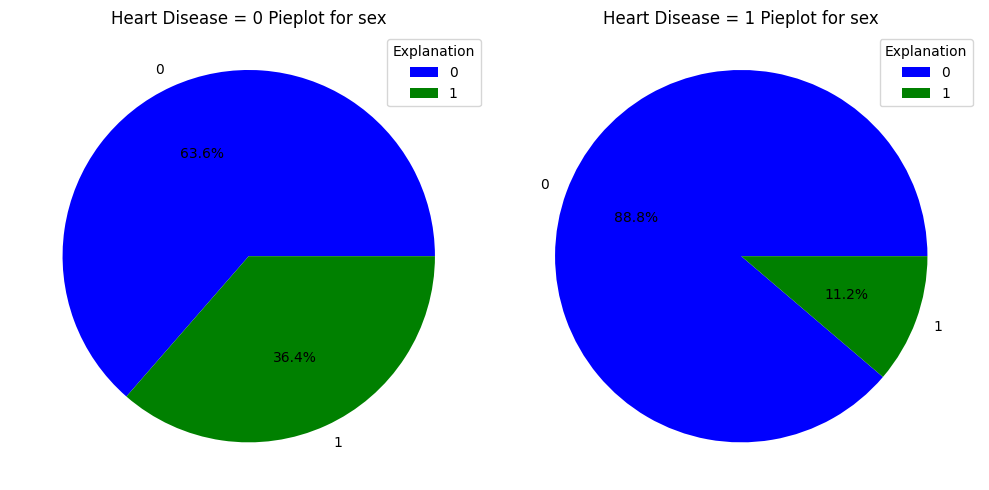

In [28]:
label_colors = {-1: 'red', 0: 'blue', 1: 'green', 2: 'brown', 3: 'orange', 4: 'purple'}

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sizes = df.loc[df['heart_disease'] == 0, 'sex'].value_counts()
labels = sizes.index
# Sort labels and sizes
labels_sorted = sorted(labels)
sizes_sorted = [sizes[label] for label in labels_sorted]
plt.pie(sizes_sorted, labels=labels_sorted, autopct='%1.1f%%', colors=[label_colors[label] for label in labels_sorted])
plt.title('Heart Disease = 0 Pieplot for sex')
plt.legend(loc='upper right', title='Explanation', labels=labels_sorted)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.subplot(1,2,2)
sizes = df.loc[df['heart_disease'] == 1, 'sex'].value_counts()
labels = sizes.index
# Sort labels and sizes
labels_sorted = sorted(labels)
sizes_sorted = [sizes[label] for label in labels_sorted]
plt.pie(sizes_sorted, labels=labels_sorted, autopct='%1.1f%%', colors=[label_colors[label] for label in labels_sorted])
plt.title('Heart Disease = 1 Pieplot for sex')
plt.legend(loc='upper right', title='Explanation', labels=labels_sorted)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

As for the 'sex' feature, the distribution of instances when 'heart_disease' = 1 and when 'heart_disease' = 0 is quite similar. The proportion of sex = 0 (male) is always larger than sex = 1 (female), but there is a slight difference between them. Specifically, the proportion of 'sex' = 1 when 'heart_disease' = 0 is much higher than when 'heart_disease' = 1, indicating that among all heart disease patients, males have more instances than females. I assume that males have a higher chance of having heart disease than females.

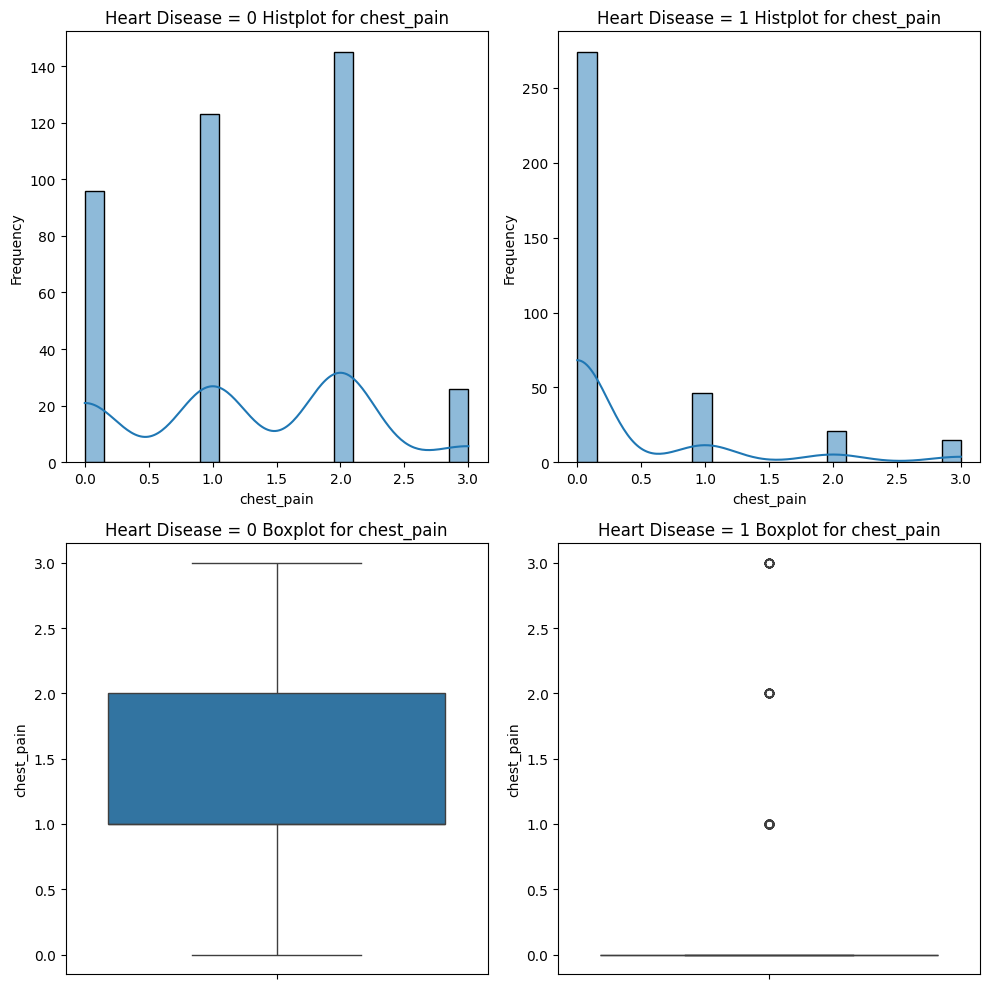

In [29]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=df.loc[df['heart_disease'] == 0], x='chest_pain', bins=20, kde=True)
plt.title('Heart Disease = 0 Histplot for chest_pain')
plt.xlabel('chest_pain')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(data=df.loc[df['heart_disease'] == 1], x='chest_pain', bins=20, kde=True)
plt.title('Heart Disease = 1 Histplot for chest_pain')
plt.xlabel('chest_pain')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.boxplot(y='chest_pain', data=df.loc[df['heart_disease'] == 0])
plt.title('Heart Disease = 0 Boxplot for chest_pain')

plt.subplot(2, 2, 4)
sns.boxplot(y='chest_pain', data=df.loc[df['heart_disease'] == 1])
plt.title('Heart Disease = 1 Boxplot for chest_pain')

plt.tight_layout()
plt.show()

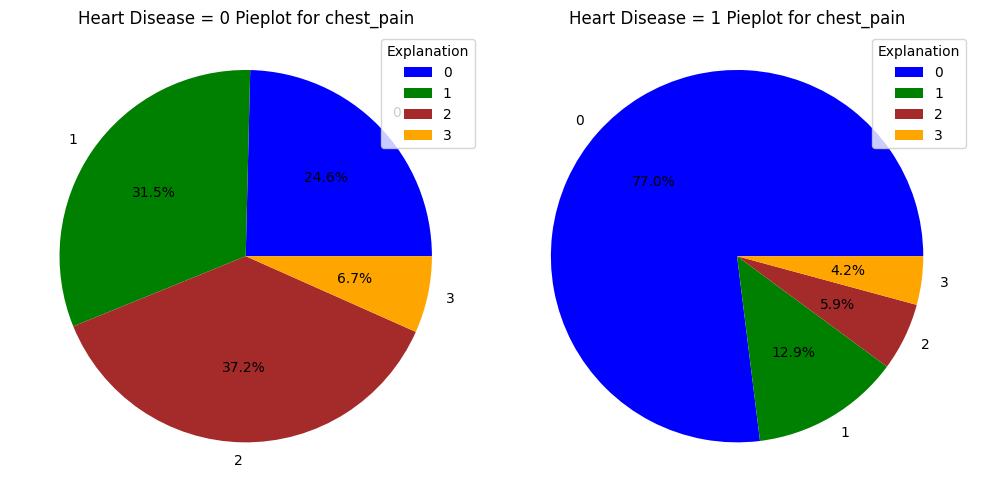

In [30]:
label_colors = {-1: 'red', 0: 'blue', 1: 'green', 2: 'brown', 3: 'orange', 4: 'purple'}

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sizes = df.loc[df['heart_disease'] == 0, 'chest_pain'].value_counts()
labels = sizes.index
# Sort labels and sizes
labels_sorted = sorted(labels)
sizes_sorted = [sizes[label] for label in labels_sorted]
plt.pie(sizes_sorted, labels=labels_sorted, autopct='%1.1f%%', colors=[label_colors[label] for label in labels_sorted])
plt.title('Heart Disease = 0 Pieplot for chest_pain')
plt.legend(loc='upper right', title='Explanation', labels=labels_sorted)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.subplot(1,2,2)
sizes = df.loc[df['heart_disease'] == 1, 'chest_pain'].value_counts()
labels = sizes.index
# Sort labels and sizes
labels_sorted = sorted(labels)
sizes_sorted = [sizes[label] for label in labels_sorted]
plt.pie(sizes_sorted, labels=labels_sorted, autopct='%1.1f%%', colors=[label_colors[label] for label in labels_sorted])
plt.title('Heart Disease = 1 Pieplot for chest_pain')
plt.legend(loc='upper right', title='Explanation', labels=labels_sorted)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

The distribution of the 'chest_pain' feature differs significantly between instances where 'heart_disease' = 1 and 'heart_disease' = 0. When 'heart_disease' = 0, the distribution appears more evenly spread across all values of the 'chest_pain' feature, where 0 representing asymptomatic, 1 representing non-anginal pain, 2 representing atypical angina, and 3 representing typical angina. In contrast, when 'heart_disease' = 1, the majority of instances focus on 'chest_pain' = 0, indicating that most instances with heart disease are asymptomatic. This suggests that the instances collected may predominantly represent minor illness cases.


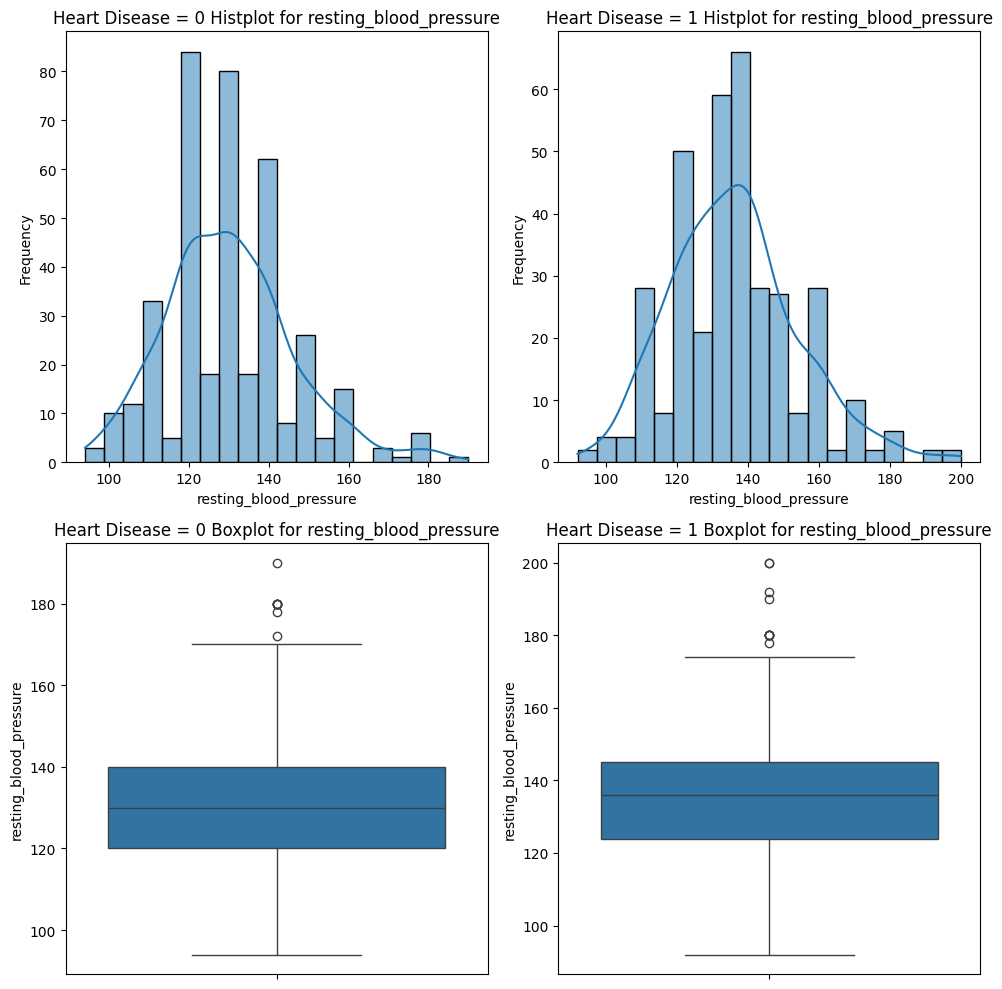

In [31]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=df.loc[df['heart_disease'] == 0], x='resting_blood_pressure', bins=20, kde=True)
plt.title('Heart Disease = 0 Histplot for resting_blood_pressure')
plt.xlabel('resting_blood_pressure')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(data=df.loc[df['heart_disease'] == 1], x='resting_blood_pressure', bins=20, kde=True)
plt.title('Heart Disease = 1 Histplot for resting_blood_pressure')
plt.xlabel('resting_blood_pressure')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.boxplot(y='resting_blood_pressure', data=df.loc[df['heart_disease'] == 0])
plt.title('Heart Disease = 0 Boxplot for resting_blood_pressure')

plt.subplot(2, 2, 4)
sns.boxplot(y='resting_blood_pressure', data=df.loc[df['heart_disease'] == 1])
plt.title('Heart Disease = 1 Boxplot for resting_blood_pressure')

plt.tight_layout()
plt.show()

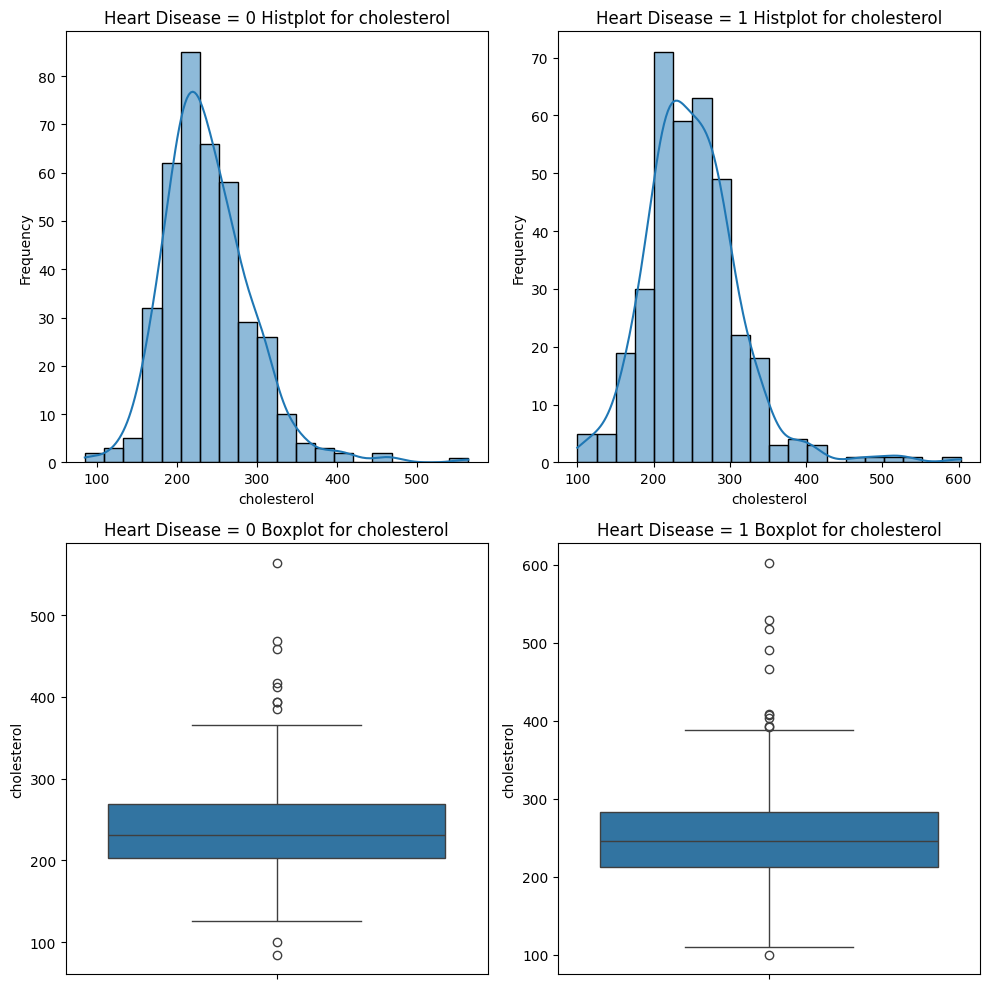

In [32]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=df.loc[df['heart_disease'] == 0], x='cholesterol', bins=20, kde=True)
plt.title('Heart Disease = 0 Histplot for cholesterol')
plt.xlabel('cholesterol')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(data=df.loc[df['heart_disease'] == 1], x='cholesterol', bins=20, kde=True)
plt.title('Heart Disease = 1 Histplot for cholesterol')
plt.xlabel('cholesterol')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.boxplot(y='cholesterol', data=df.loc[df['heart_disease'] == 0])
plt.title('Heart Disease = 0 Boxplot for cholesterol')

plt.subplot(2, 2, 4)
sns.boxplot(y='cholesterol', data=df.loc[df['heart_disease'] == 1])
plt.title('Heart Disease = 1 Boxplot for cholesterol')

plt.tight_layout()
plt.show()

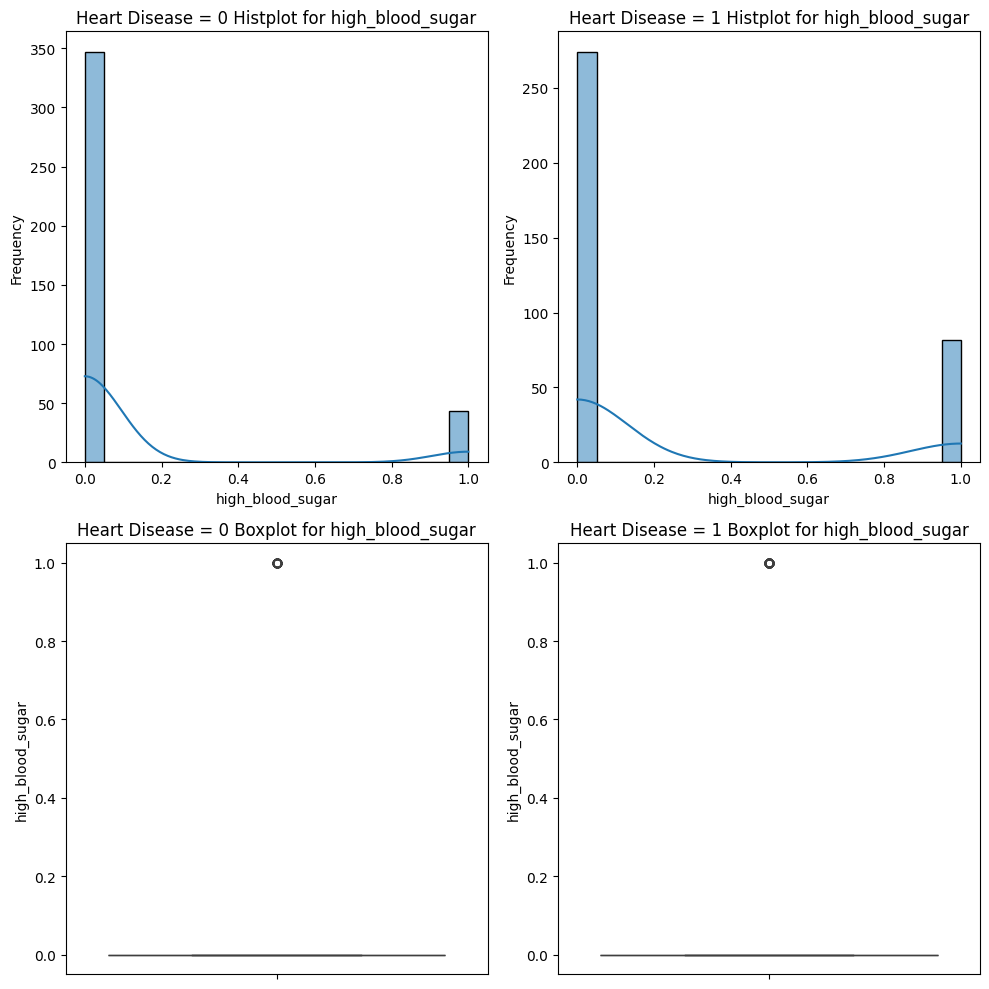

In [33]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=df.loc[df['heart_disease'] == 0], x='high_blood_sugar', bins=20, kde=True)
plt.title('Heart Disease = 0 Histplot for high_blood_sugar')
plt.xlabel('high_blood_sugar')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(data=df.loc[df['heart_disease'] == 1], x='high_blood_sugar', bins=20, kde=True)
plt.title('Heart Disease = 1 Histplot for high_blood_sugar')
plt.xlabel('high_blood_sugar')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.boxplot(y='high_blood_sugar', data=df.loc[df['heart_disease'] == 0])
plt.title('Heart Disease = 0 Boxplot for high_blood_sugar')

plt.subplot(2, 2, 4)
sns.boxplot(y='high_blood_sugar', data=df.loc[df['heart_disease'] == 1])
plt.title('Heart Disease = 1 Boxplot for high_blood_sugar')

plt.tight_layout()
plt.show()

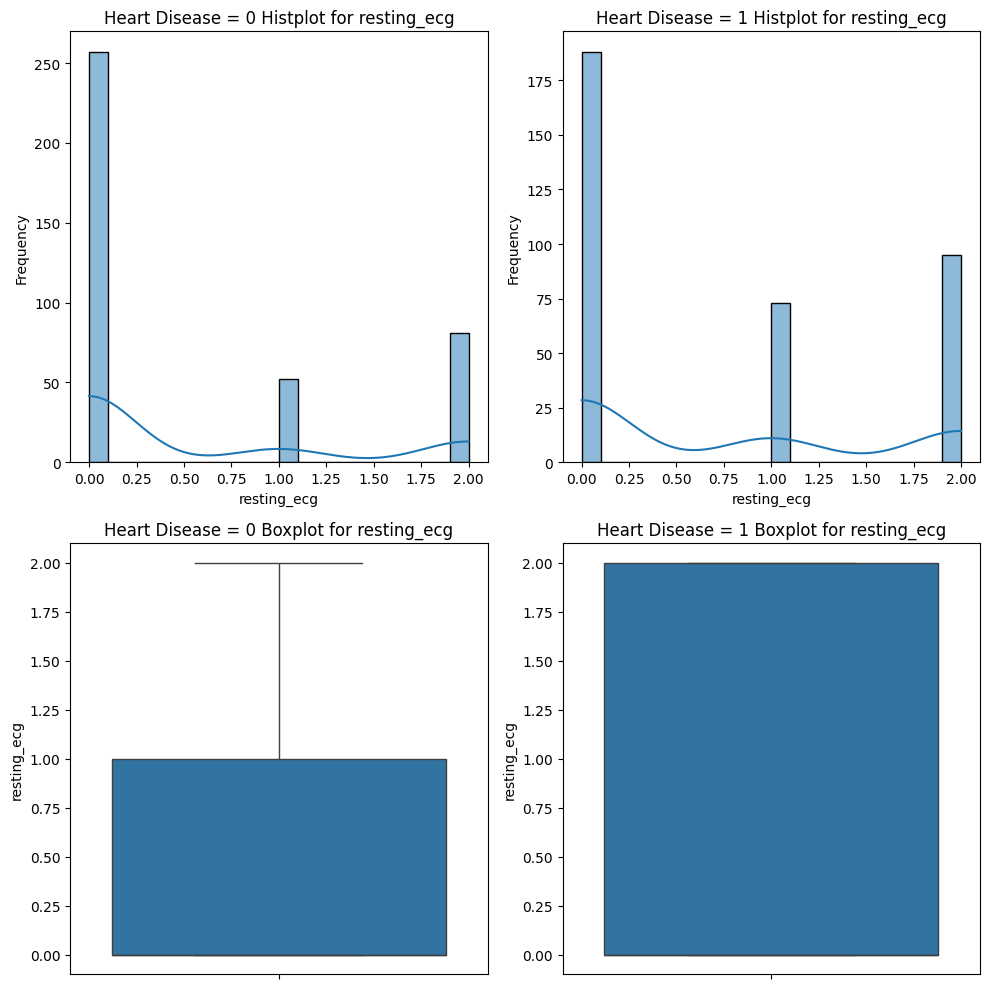

In [34]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=df.loc[df['heart_disease'] == 0], x='resting_ecg', bins=20, kde=True)
plt.title('Heart Disease = 0 Histplot for resting_ecg')
plt.xlabel('resting_ecg')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(data=df.loc[df['heart_disease'] == 1], x='resting_ecg', bins=20, kde=True)
plt.title('Heart Disease = 1 Histplot for resting_ecg')
plt.xlabel('resting_ecg')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.boxplot(y='resting_ecg', data=df.loc[df['heart_disease'] == 0])
plt.title('Heart Disease = 0 Boxplot for resting_ecg')

plt.subplot(2, 2, 4)
sns.boxplot(y='resting_ecg', data=df.loc[df['heart_disease'] == 1])
plt.title('Heart Disease = 1 Boxplot for resting_ecg')

plt.tight_layout()
plt.show()

For features with weak correlations, such as 'resting_blood_pressure', 'cholesterol', 'high_blood_sugar', and 'resting_ecg', we can observe similar distributions in both cases where 'heart_disease' = 0 and 'heart_disease' = 1. The main difference is the proportion of each feature value in each case. Particularly in the cases of 'high_blood_sugar' and 'resting_ecg', the distributions resemble that of the 'sex' feature case, but the differences are not large enough to be of concern, unlike in the 'sex' feature case.

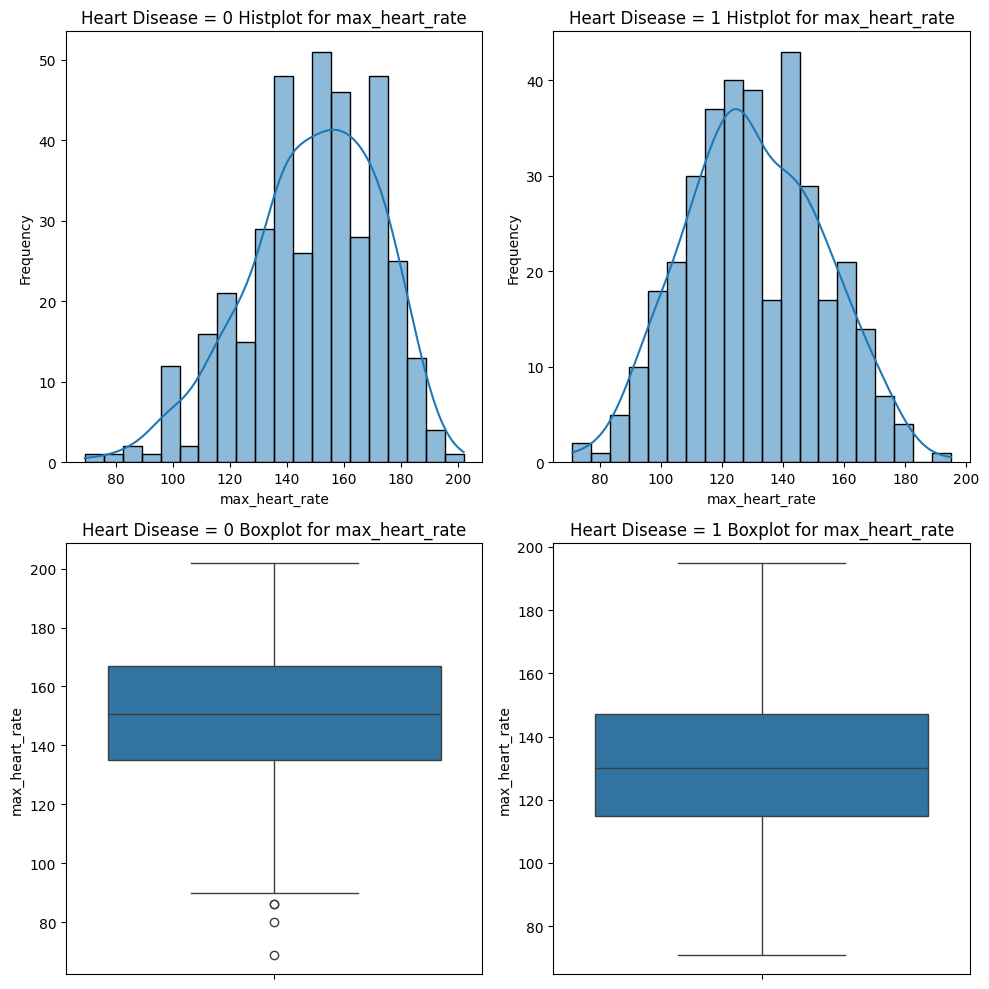

In [35]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=df.loc[df['heart_disease'] == 0], x='max_heart_rate', bins=20, kde=True)
plt.title('Heart Disease = 0 Histplot for max_heart_rate')
plt.xlabel('max_heart_rate')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(data=df.loc[df['heart_disease'] == 1], x='max_heart_rate', bins=20, kde=True)
plt.title('Heart Disease = 1 Histplot for max_heart_rate')
plt.xlabel('max_heart_rate')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.boxplot(y='max_heart_rate', data=df.loc[df['heart_disease'] == 0])
plt.title('Heart Disease = 0 Boxplot for max_heart_rate')

plt.subplot(2, 2, 4)
sns.boxplot(y='max_heart_rate', data=df.loc[df['heart_disease'] == 1])
plt.title('Heart Disease = 1 Boxplot for max_heart_rate')

plt.tight_layout()
plt.show()

In the case of the 'max_heart_rate' feature, It is similar to the 'age' feature in that its distribution is clearly divided into two ranges for the two different 'heart_disease' labels. However, it is opposite to the 'age' feature in that when 'heart_disease' = 0, most instances focus on a range higher than 140. Conversely, when 'heart_disease' = 1, a significant number of instances focus on a range lower than 140.

So I engineered a new feature by dividing the 'max_heart_rate' feature into two ranges: one for values lower than 140 presented by 1 and another for values higher than 140 presented by 2.

In [36]:
low_max_hr = (df['max_heart_rate']<140)*1
high_max_hr = (df['max_heart_rate']>=140)*2
df['max_heart_rate_range'] = low_max_hr + high_max_hr

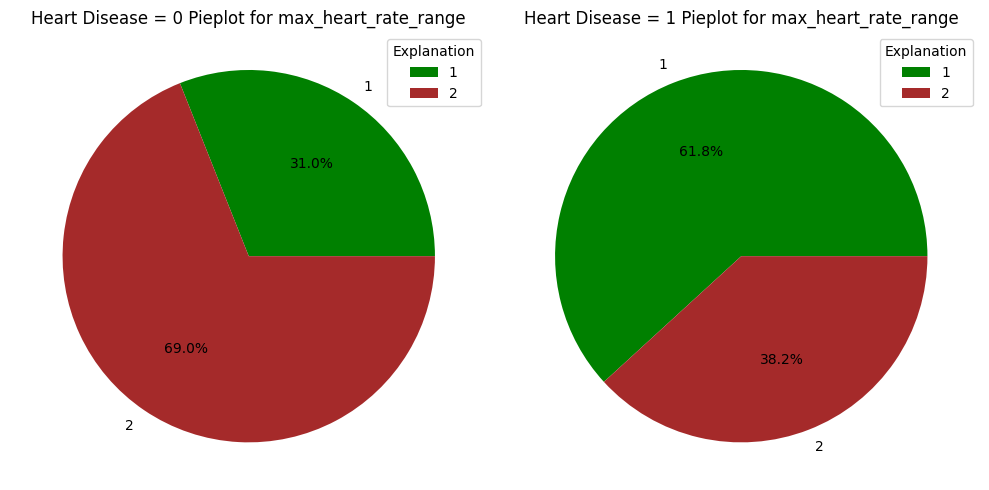

In [37]:
label_colors = {-1: 'red', 0: 'blue', 1: 'green', 2: 'brown', 3: 'orange', 4: 'purple'}

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sizes = df.loc[df['heart_disease'] == 0, 'max_heart_rate_range'].value_counts()
labels = sizes.index
# Sort labels and sizes
labels_sorted = sorted(labels)
sizes_sorted = [sizes[label] for label in labels_sorted]
plt.pie(sizes_sorted, labels=labels_sorted, autopct='%1.1f%%', colors=[label_colors[label] for label in labels_sorted])
plt.title('Heart Disease = 0 Pieplot for max_heart_rate_range')
plt.legend(loc='upper right', title='Explanation', labels=labels_sorted)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.subplot(1,2,2)
sizes = df.loc[df['heart_disease'] == 1, 'max_heart_rate_range'].value_counts()
labels = sizes.index
# Sort labels and sizes
labels_sorted = sorted(labels)
sizes_sorted = [sizes[label] for label in labels_sorted]
plt.pie(sizes_sorted, labels=labels_sorted, autopct='%1.1f%%', colors=[label_colors[label] for label in labels_sorted])
plt.title('Heart Disease = 1 Pieplot for max_heart_rate_range')
plt.legend(loc='upper right', title='Explanation', labels=labels_sorted)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

The pie plots show us a clearer difference in distribution between both cases of 'heart_disease' from the two ranges of maximum heart rate values, which I named 'max_heart_rate_range'.

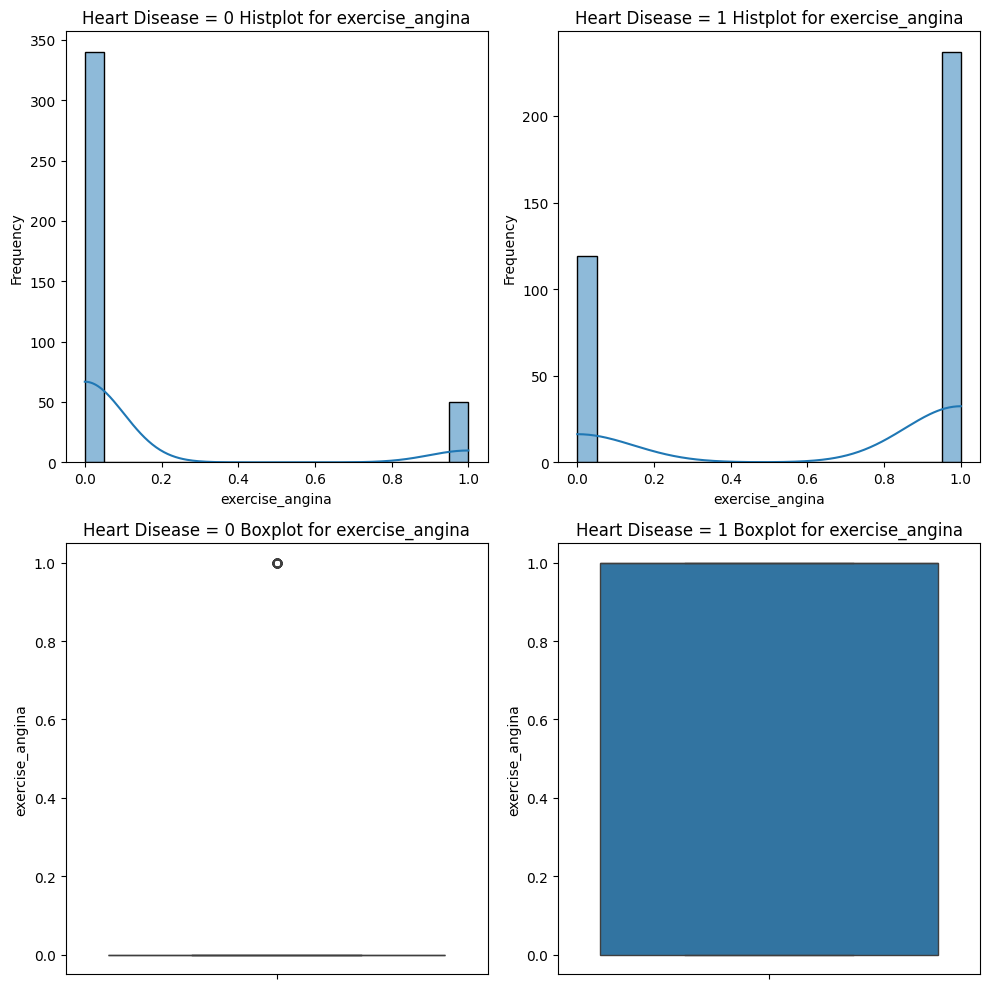

In [38]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=df.loc[df['heart_disease'] == 0], x='exercise_angina', bins=20, kde=True)
plt.title('Heart Disease = 0 Histplot for exercise_angina')
plt.xlabel('exercise_angina')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(data=df.loc[df['heart_disease'] == 1], x='exercise_angina', bins=20, kde=True)
plt.title('Heart Disease = 1 Histplot for exercise_angina')
plt.xlabel('exercise_angina')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.boxplot(y='exercise_angina', data=df.loc[df['heart_disease'] == 0])
plt.title('Heart Disease = 0 Boxplot for exercise_angina')

plt.subplot(2, 2, 4)
sns.boxplot(y='exercise_angina', data=df.loc[df['heart_disease'] == 1])
plt.title('Heart Disease = 1 Boxplot for exercise_angina')

plt.tight_layout()
plt.show()

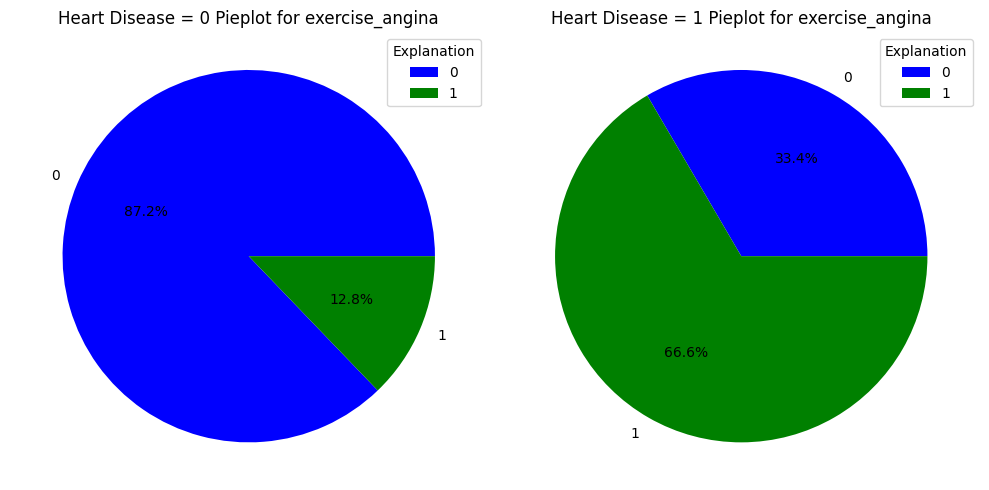

In [39]:
label_colors = {-1: 'red', 0: 'blue', 1: 'green', 2: 'brown', 3: 'orange', 4: 'purple'}

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sizes = df.loc[df['heart_disease'] == 0, 'exercise_angina'].value_counts()
labels = sizes.index
# Sort labels and sizes
labels_sorted = sorted(labels)
sizes_sorted = [sizes[label] for label in labels_sorted]
plt.pie(sizes_sorted, labels=labels_sorted, autopct='%1.1f%%', colors=[label_colors[label] for label in labels_sorted])
plt.title('Heart Disease = 0 Pieplot for exercise_angina')
plt.legend(loc='upper right', title='Explanation', labels=labels_sorted)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.subplot(1,2,2)
sizes = df.loc[df['heart_disease'] == 1, 'exercise_angina'].value_counts()
labels = sizes.index
# Sort labels and sizes
labels_sorted = sorted(labels)
sizes_sorted = [sizes[label] for label in labels_sorted]
plt.pie(sizes_sorted, labels=labels_sorted, autopct='%1.1f%%', colors=[label_colors[label] for label in labels_sorted])
plt.title('Heart Disease = 1 Pieplot for exercise_angina')
plt.legend(loc='upper right', title='Explanation', labels=labels_sorted)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

The distribution of the 'exercise_angina' feature shows a significant difference between instances where 'heart_disease' = 0 and 'heart_disease' = 1. Specifically, 66.6% of instances with heart disease exhibit exercise angina, while 87.2% of instances without heart disease do not show any problems with exercise angina. Showing that this 'exercise_angina' feature is very important.

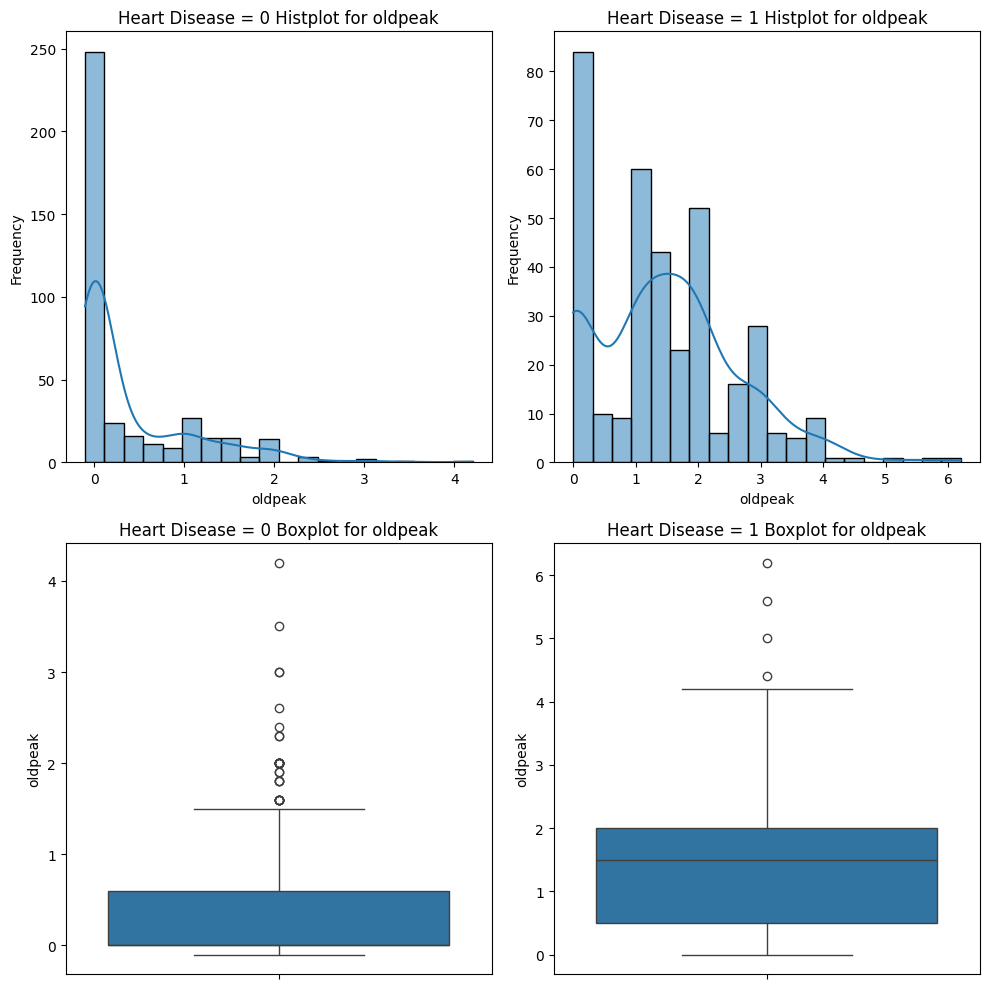

In [40]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=df.loc[df['heart_disease'] == 0], x='oldpeak', bins=20, kde=True)
plt.title('Heart Disease = 0 Histplot for oldpeak')
plt.xlabel('oldpeak')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(data=df.loc[df['heart_disease'] == 1], x='oldpeak', bins=20, kde=True)
plt.title('Heart Disease = 1 Histplot for oldpeak')
plt.xlabel('oldpeak')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.boxplot(y='oldpeak', data=df.loc[df['heart_disease'] == 0])
plt.title('Heart Disease = 0 Boxplot for oldpeak')

plt.subplot(2, 2, 4)
sns.boxplot(y='oldpeak', data=df.loc[df['heart_disease'] == 1])
plt.title('Heart Disease = 1 Boxplot for oldpeak')

plt.tight_layout()
plt.show()

In the medical context, 'oldpeak' typically refers to the ST depression induced by exercise relative to rest. This parameter is often utilized in cardiac stress testing to evaluate the severity of coronary artery disease. Through the distribution of 'oldpeak', it becomes evident that most instances without heart disease tend to have an oldpeak value around 0. This suggests that if oldpeak is 0, it often implies that the patient's heart is likely to function normally during physical exertion, without any ischemia (lack of blood flow) or other abnormalities detected by the ST segment changes. However, in instances where 'heart_disease' = 1, there are many instances with oldpeak values different from 1. In the context of this dataset, most of them are greater than 0, but based on my research, it could also be lesser than 0.

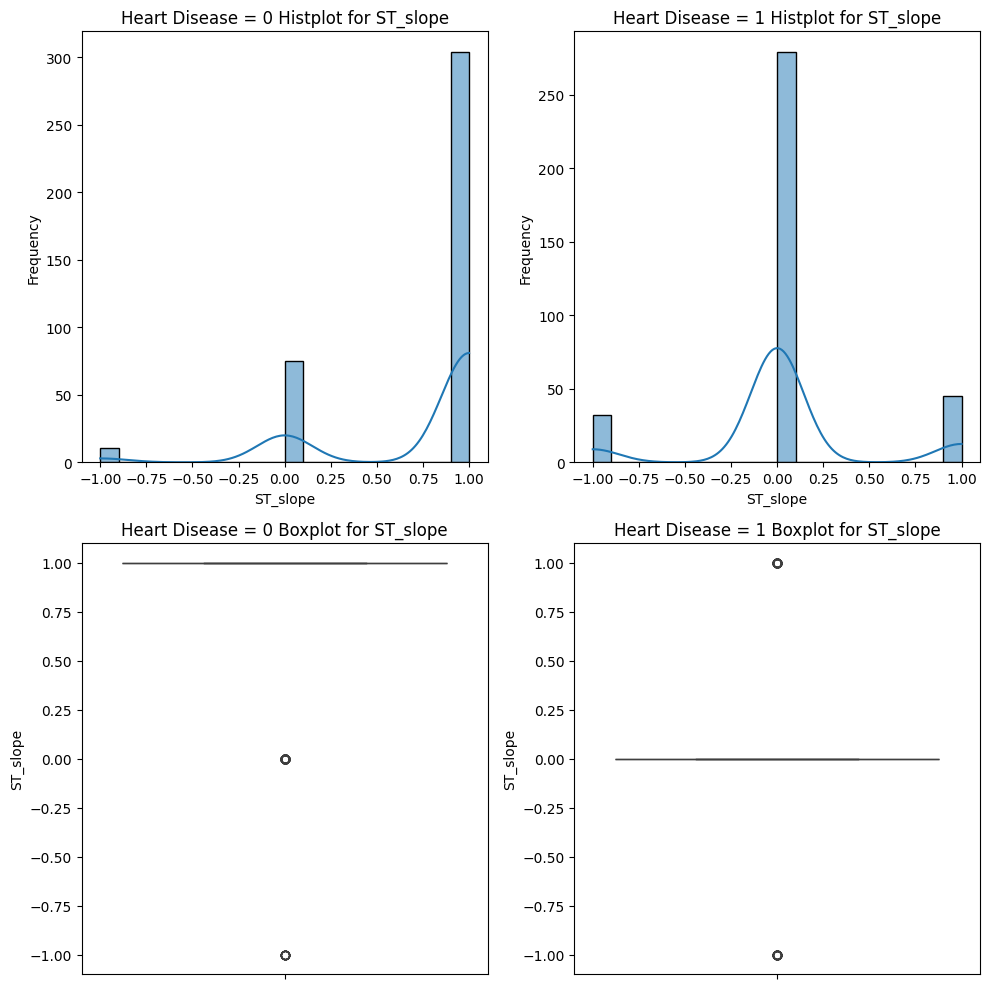

In [41]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=df.loc[df['heart_disease'] == 0], x='ST_slope', bins=20, kde=True)
plt.title('Heart Disease = 0 Histplot for ST_slope')
plt.xlabel('ST_slope')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(data=df.loc[df['heart_disease'] == 1], x='ST_slope', bins=20, kde=True)
plt.title('Heart Disease = 1 Histplot for ST_slope')
plt.xlabel('ST_slope')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.boxplot(y='ST_slope', data=df.loc[df['heart_disease'] == 0])
plt.title('Heart Disease = 0 Boxplot for ST_slope')

plt.subplot(2, 2, 4)
sns.boxplot(y='ST_slope', data=df.loc[df['heart_disease'] == 1])
plt.title('Heart Disease = 1 Boxplot for ST_slope')

plt.tight_layout()
plt.show()

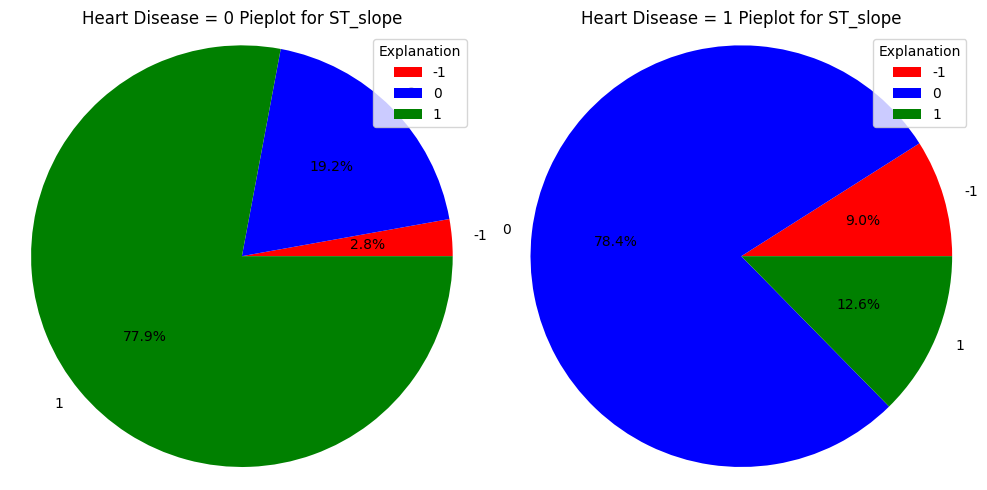

In [42]:
label_colors = {-1: 'red', 0: 'blue', 1: 'green', 2: 'brown', 3: 'orange', 4: 'purple'}

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sizes = df.loc[df['heart_disease'] == 0, 'ST_slope'].value_counts()
labels = sizes.index
# Sort labels and sizes
labels_sorted = sorted(labels)
sizes_sorted = [sizes[label] for label in labels_sorted]
plt.pie(sizes_sorted, labels=labels_sorted, autopct='%1.1f%%', colors=[label_colors[label] for label in labels_sorted])
plt.title('Heart Disease = 0 Pieplot for ST_slope')
plt.legend(loc='upper right', title='Explanation', labels=labels_sorted)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.subplot(1,2,2)
sizes = df.loc[df['heart_disease'] == 1, 'ST_slope'].value_counts()
labels = sizes.index
# Sort labels and sizes
labels_sorted = sorted(labels)
sizes_sorted = [sizes[label] for label in labels_sorted]
plt.pie(sizes_sorted, labels=labels_sorted, autopct='%1.1f%%', colors=[label_colors[label] for label in labels_sorted])
plt.title('Heart Disease = 1 Pieplot for ST_slope')
plt.legend(loc='upper right', title='Explanation', labels=labels_sorted)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

In the case of 'ST_slope' distribution, it is notable that most instances with 'heart_disease' = 0 have an ST slope value of 1, indicating upsloping of the ST segment. Conversely, in instances where 'heart_disease' = 1, the majority focus on an ST slope value of 0, representing a flat ST segment. Additionally, instances with an ST slope value of -1, indicating downsloping of the ST segment, have a higher number of occurrences compared to instances where 'heart_disease' = 0. This underscores the importance of the 'ST_slope' feature in predicting heart disease.

**Model Development**

In [43]:
X = df.drop(columns='heart_disease')
y = df['heart_disease']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,age,sex,chest_pain,resting_blood_pressure,cholesterol,high_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,ST_slope,age_range,max_heart_rate_range
70,57,0,2,140,265,0,1,145,1,1.0,0,2,2
165,52,1,2,140,225,0,0,140,0,0.0,1,1,2
884,56,1,2,140,294,0,2,153,0,1.3,0,2,2
266,54,0,2,160,305,0,0,175,0,0.0,1,2,2
251,44,0,0,135,491,0,0,135,0,0.0,0,1,1


In [45]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Logistic Regression': LogisticRegression()
}
accuracy_train_set = {}
accuracy_test_set = {}
precision = {}
recall = {}
f1Score = {}

for name, model in tqdm(models.items()):
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)

    accuracy_train_set[name] = model.score(X_train_scaled, y_train)
    accuracy_test_set[name] = model.score(X_test_scaled, y_test)
    precision[name] = precision_score(y_test,predictions,average='weighted')
    recall[name] = recall_score(y_test,predictions,average='weighted')
    f1Score[name] = f1_score(y_test,predictions,average='weighted')
    print('\n',name)
    print(classification_report(y_test, predictions))

accuracy_train_set = pd.DataFrame(accuracy_train_set, index = ['accuracy of model']).T
accuracy_test_set = pd.DataFrame(accuracy_test_set, index = ['accuracy of model']).T
precision = pd.DataFrame(precision, index = ['precision of model']).T
recall = pd.DataFrame(recall, index = ['recall of model']).T
f1Score = pd.DataFrame(f1Score, index = ['f1Score of model']).T

# Assuming accuracy, precision, recall, and f1Score are DataFrames or Series
# Merging these metrics into a single DataFrame
results = pd.concat([accuracy_train_set, accuracy_test_set, precision, recall, f1Score], axis=1)
results.columns = ['Accuracy Train Set', 'Accuracy Test Set', 'Precision', 'Recall', 'F1-Score']

# Applying styling to highlight maximum and minimum values
styled_results = results.style.highlight_max(color='green').highlight_min(color='red')

styled_results

100%|██████████| 4/4 [00:00<00:00, 10.66it/s]


 Random Forest
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        71
           1       0.94      0.86      0.90        79

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150


 k-Nearest Neighbors
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        71
           1       0.92      0.85      0.88        79

    accuracy                           0.88       150
   macro avg       0.88      0.88      0.88       150
weighted avg       0.88      0.88      0.88       150


 Support Vector Machine
              precision    recall  f1-score   support

           0       0.86      0.92      0.88        71
           1       0.92      0.86      0.89        79

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted av

,Accuracy Train Set,Accuracy Test Set,Precision,Recall,F1-Score
Random Forest,1.000000,0.900000,0.903989,0.900000,0.900031
k-Nearest Neighbors,0.879195,0.880000,0.882946,0.880000,0.880064
Support Vector Machine,0.899329,0.886667,0.888789,0.886667,0.886742
Logistic Regression,0.852349,0.860000,0.860875,0.860000,0.860093


In [47]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced']
}

# Create SVM model
svm_model = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=20, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Evaluate the best model
best_model = grid_search.best_estimator_
best_model_score = best_model.score(X_test_scaled, y_test)

y_pred = grid_search.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89        71
           1       0.92      0.87      0.90        79

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



In [48]:
print(f'Accuracy train set:     {best_model.score(X_train_scaled, y_train)}')
print(f'Accuracy test set:      {best_model.score(X_test_scaled, y_test)}')
print(f'Precision:              {precision_score(y_test, y_pred,average="weighted")}')
print(f'Recall:                 {recall_score(y_test, y_pred,average="weighted")}')
print(f'f1:                     {f1_score(y_test, y_pred,average="weighted")}')

Accuracy train set:     0.9093959731543624
Accuracy test set:      0.8933333333333333
Precision:              0.8947555555555556
Recall:                 0.8933333333333333
f1:                     0.8934092391626636
